## Segmentenvergleich Tageskurven


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dtaidistance.dtw import distance as dtw_dist
from scipy.spatial.distance import cityblock, euclidean
import seaborn as sns
from yellowbrick.cluster import elbow, SilhouetteVisualizer, silhouette_visualizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
%matplotlib inline

# Filtering warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import Fred as fred
import math

# Create own Distance Measures and import from Fred-Frechet

# Discrete Frechet
def disc_frechet(x, y):
    a = fred.Curve(x)
    b = fred.Curve(y)
    dist = fred.discrete_frechet(a, b)
    return dist.value

# Discrete Dynamic Time Warping
def disc_dtw(x, y):
    a = fred.Curve(x)
    b = fred.Curve(y)
    dist = fred.discrete_dynamic_time_warping(a, b)
    return dist.value

# Discrete Dynamic Time Warping with traversal constraint
def window_ddtw(x, y, w=4):
    n = len(x)
    m = len(y)

    # maximal possible windowsize
    w = max(w, abs(n-m))

    # distancematrix filled with infinity
    dtw = np.full((n, m), math.inf)
    dtw[0, 0] = 0

    # all possible paths filled with zeros
    for i in range(1, n):
        for j in range(max(1, i-w), min(m, i+w)):
            cost = (x[i] - y[j])**2
            dtw[i, j] = cost + min(dtw[i-1, j],
                                   dtw[i, j-1],
                                   dtw[i-1, j-1])

    return math.sqrt(dtw[n-1, m-1])

# Discrete Frechet with traversal constraint
def window_disc_frechet(x, y, w=4):
    n = len(x)
    m = len(y)

    # maximal possible windowsize
    w = max(w, abs(n-m))

    # distancematrix filled with infinity
    dfre = np.full((n, m), math.inf)
    dfre[0, 0] = 0

    # all possible paths filled with zeros
    for i in range(1, n):
        for j in range(max(1, i-w), min(m, i+w)):
            cost = (x[i] - y[j])**2
            dfre[i, j] = max(cost, min(dfre[i-1, j],
                                       dfre[i, j-1],
                                       dfre[i-1, j-1]))

    return math.sqrt(dfre[n-1, m-1])

# k-greatest-distances-Mahnhattandistanz
def k_greatest_manhattan(x, y, w=6):
    dists = np.abs(x - y)
    return np.sum(np.sort(dists)[-w:][::-1])

# Earth mover's distance
from scipy.stats import wasserstein_distance

def emd(u, v):
    if u.sum() == 0:
        return 0.001 #math.inf
    elif v.sum() == 0:
        return 0.001 #math.inf
    else:
        # create bin-vectors
        bin_u = [i for i in range(0, len(u))]
        bin_v = [i for i in range(0, len(v))]

        # normalize input vectors to unit-vectors
        u_norm = u / np.linalg.norm(u, ord=1)
        v_norm = v / np.linalg.norm(v, ord=1)        
        
        return wasserstein_distance(bin_u, bin_v, u_norm, v_norm)

def dtw_ai(x, y, w=None):
    return dtw_dist(x, y, window=w, use_c=True)

## Segmentierte Kurven

Kurven von Zeiträumen sieben Tagen vor den Examina

In [4]:
## K1
alle = pd.read_csv("")
# -97 rausschmeissen
alle = alle.drop(alle[alle.final_result < 0].index)
y = alle.final_result.copy()

#  "A" vs. "C und schlechter"
alle = alle.drop(alle[(alle.final_result > 6) & (alle.final_result < 10)].index)
y = alle.final_result.copy()

seg1 = np.log1p(alle.loc[:, 'day16':'day22'])
seg2 = np.log1p(alle.loc[:, 'day44':'day50'])
seg3 = np.log1p(alle.loc[:, 'day67':'day73'])

s1 = seg1.to_numpy(dtype='float')
s2 = seg2.to_numpy(dtype='float')
s3 = seg3.to_numpy(dtype='float')

## Vergleich der Segmente mit DTW
mat = []
for i in range(0, len(seg1)):
    mat.append([dtw_ai(s1[i], s2[i]), dtw_ai(s1[i], s3[i]), dtw_ai(s2[i], s3[i])])
    
## binäres Problem
y[y < 10] = 0
y[y > 0] = 1
print('Notenverteilung:', y.value_counts())

#Anzahl Studis
print(len(y))

X = pd.DataFrame(mat)
km = KMeans(n_clusters=5, random_state=1971, n_init="auto").fit(X)
X['cluster'] = km.labels_

for i in range(5):
    print('Cluster' + str(i), ':\n', y[km.labels_ == i].value_counts().sort_index())

# dataframe mit Clusterzugehörigkeiten
df1 = pd.concat([y[km.labels_ == i].value_counts().sort_index().rename_axis(None).reset_index(name='counts').transpose() for i in range(5)], axis=1)
df1 = df1.drop('index').rename({'counts': 'K1'})

X = X.rename(columns={0: '$s_1:s_2$', 1: '$s_1:s_3$', 2: '$s_2:s_3$'})
df_long2 = X.melt(id_vars='cluster', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

X['final'] = y.values
X = X.drop('cluster', axis=1)
df_long22 = X.melt(id_vars='final', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

Notenverteilung: 1    166
0     55
Name: final_result, dtype: int64
221
Cluster0 :
 0    14
1    34
Name: final_result, dtype: int64
Cluster1 :
 0    11
1    61
Name: final_result, dtype: int64
Cluster2 :
 0    18
1    34
Name: final_result, dtype: int64
Cluster3 :
 0     6
1    31
Name: final_result, dtype: int64
Cluster4 :
 0    6
1    6
Name: final_result, dtype: int64


In [5]:
## K2
alle = pd.read_csv("")
# -97 rausschmeissen
alle = alle.drop(alle[alle.final_result < 0].index)
y = alle.final_result.copy()

#  "A" vs. "C und schlechter"
alle = alle.drop(alle[(alle.final_result > 6) & (alle.final_result < 10)].index)
y = alle.final_result.copy()

seg1 = np.log1p(alle.loc[:, 'day16':'day22'])
seg2 = np.log1p(alle.loc[:, 'day44':'day50'])
seg3 = np.log1p(alle.loc[:, 'day67':'day73'])

s1 = seg1.to_numpy(dtype='float')
s2 = seg2.to_numpy(dtype='float')
s3 = seg3.to_numpy(dtype='float')

## Vergleich der Segmente mit DTW
mat = []
for i in range(0, len(seg1)):
    mat.append([dtw_ai(s1[i], s2[i]), dtw_ai(s1[i], s3[i]), dtw_ai(s2[i], s3[i])])
    
## binäres Problem
y[y < 10] = 0
y[y > 0] = 1
print('Notenverteilung:', y.value_counts())

#Anzahl Studis
print(len(y))

X = pd.DataFrame(mat)
km = KMeans(n_clusters=5, random_state=1971, n_init="auto").fit(X)
X['cluster'] = km.labels_

for i in range(5):
    print('Cluster' + str(i), ':\n', y[km.labels_ == i].value_counts().sort_index())

# dataframe mit Clusterzugehörigkeiten
df2 = pd.concat([y[km.labels_ == i].value_counts().sort_index().rename_axis(None).reset_index(name='counts').transpose() for i in range(5)], axis=1)
df2 = df2.drop('index').rename({'counts': 'K2'})

X = X.rename(columns={0: '$s_1:s_2$', 1: '$s_1:s_3$', 2: '$s_2:s_3$'})
df_long4 = X.melt(id_vars='cluster', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

X['final'] = y.values
X = X.drop('cluster', axis=1)
df_long44 = X.melt(id_vars='final', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

Notenverteilung: 0    103
1    102
Name: final_result, dtype: int64
205
Cluster0 :
 0    17
1    13
Name: final_result, dtype: int64
Cluster1 :
 0    14
1    21
Name: final_result, dtype: int64
Cluster2 :
 0    21
1    29
Name: final_result, dtype: int64
Cluster3 :
 0    22
1    16
Name: final_result, dtype: int64
Cluster4 :
 0    29
1    23
Name: final_result, dtype: int64


In [6]:
## 40060
alle = pd.read_csv("")
# -97 rausschmeissen
alle = alle.drop(alle[alle.final_result < 0].index)
y = alle.final_result.copy()

#  "A" vs. "C und schlechter"
alle = alle.drop(alle[(alle.final_result > 6) & (alle.final_result < 10)].index)
y = alle.final_result.copy()

seg1 = np.log1p(alle.loc[:, 'day16':'day22'])
seg2 = np.log1p(alle.loc[:, 'day44':'day50'])
seg3 = np.log1p(alle.loc[:, 'day67':'day73'])

s1 = seg1.to_numpy(dtype='float')
s2 = seg2.to_numpy(dtype='float')
s3 = seg3.to_numpy(dtype='float')

## Vergleich der Segmente mit DTW
mat = []
for i in range(0, len(seg1)):
    mat.append([dtw_ai(s1[i], s2[i]), dtw_ai(s1[i], s3[i]), dtw_ai(s2[i], s3[i])])
    
## binäres Problem
y[y < 10] = 0
y[y > 0] = 1
print('Notenverteilung:', y.value_counts())

#Anzahl Studis
print(len(y))

X = pd.DataFrame(mat)
km = KMeans(n_clusters=5, random_state=1971, n_init="auto").fit(X)
X['cluster'] = km.labels_

for i in range(5):
    print('Cluster' + str(i), ':\n', y[km.labels_ == i].value_counts().sort_index())

# dataframe mit Clusterzugehörigkeiten
df3 = pd.concat([y[km.labels_ == i].value_counts().sort_index().rename_axis(None).reset_index(name='counts').transpose() for i in range(5)], axis=1)
df3 = df3.drop('index').rename({'counts': 'K3'})

X = X.rename(columns={0: '$s_1:s_2$', 1: '$s_1:s_3$', 2: '$s_2:s_3$'})
df_long6 = X.melt(id_vars='cluster', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

X['final'] = y.values
X = X.drop('cluster', axis=1)
df_long66 = X.melt(id_vars='final', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

Notenverteilung: 0    119
1     94
Name: final_result, dtype: int64
213
Cluster0 :
 0    21
1    14
Name: final_result, dtype: int64
Cluster1 :
 0    20
1    12
Name: final_result, dtype: int64
Cluster2 :
 0    37
1    46
Name: final_result, dtype: int64
Cluster3 :
 0    27
1    17
Name: final_result, dtype: int64
Cluster4 :
 0    14
1     5
Name: final_result, dtype: int64


In [7]:
## 40080
alle = pd.read_csv("")
# -97 rausschmeissen
alle = alle.drop(alle[alle.final_result < 0].index)
y = alle.final_result.copy()

#  "A" vs. "C und schlechter"
alle = alle.drop(alle[(alle.final_result > 6) & (alle.final_result < 10)].index)
y = alle.final_result.copy()

seg1 = np.log1p(alle.loc[:, 'day16':'day22'])
seg2 = np.log1p(alle.loc[:, 'day44':'day50'])
seg3 = np.log1p(alle.loc[:, 'day67':'day73'])

s1 = seg1.to_numpy(dtype='float')
s2 = seg2.to_numpy(dtype='float')
s3 = seg3.to_numpy(dtype='float')

## Vergleich der Segmente mit DTW
mat = []
for i in range(0, len(seg1)):
    mat.append([dtw_ai(s1[i], s2[i]), dtw_ai(s1[i], s3[i]), dtw_ai(s2[i], s3[i])])
    
## binäres Problem
y[y < 10] = 0
y[y > 0] = 1
print('Notenverteilung:', y.value_counts())

#Anzahl Studis
print(len(y))

X = pd.DataFrame(mat)
km = KMeans(n_clusters=5, random_state=1971, n_init="auto").fit(X)
X['cluster'] = km.labels_

for i in range(5):
    print('Cluster' + str(i), ':\n', y[km.labels_ == i].value_counts().sort_index())

# dataframe mit Clusterzugehörigkeiten
df4 = pd.concat([y[km.labels_ == i].value_counts().sort_index().rename_axis(None).reset_index(name='counts').transpose() for i in range(5)], axis=1)
df4 = df4.drop('index').rename({'counts': 'K4'})

X = X.rename(columns={0: '$s_1:s_2$', 1: '$s_1:s_3$', 2: '$s_2:s_3$'})
df_long8 = X.melt(id_vars='cluster', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

X['final'] = y.values
X = X.drop('cluster', axis=1)
df_long88 = X.melt(id_vars='final', value_vars=X.columns[:-1], var_name='segment', value_name='distance')

Notenverteilung: 1    122
0    102
Name: final_result, dtype: int64
224
Cluster0 :
 0     9
1    25
Name: final_result, dtype: int64
Cluster1 :
 0    14
1    33
Name: final_result, dtype: int64
Cluster2 :
 0    19
1    14
Name: final_result, dtype: int64
Cluster3 :
 0    29
1    24
Name: final_result, dtype: int64
Cluster4 :
 0    31
1    26
Name: final_result, dtype: int64


In [9]:
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator

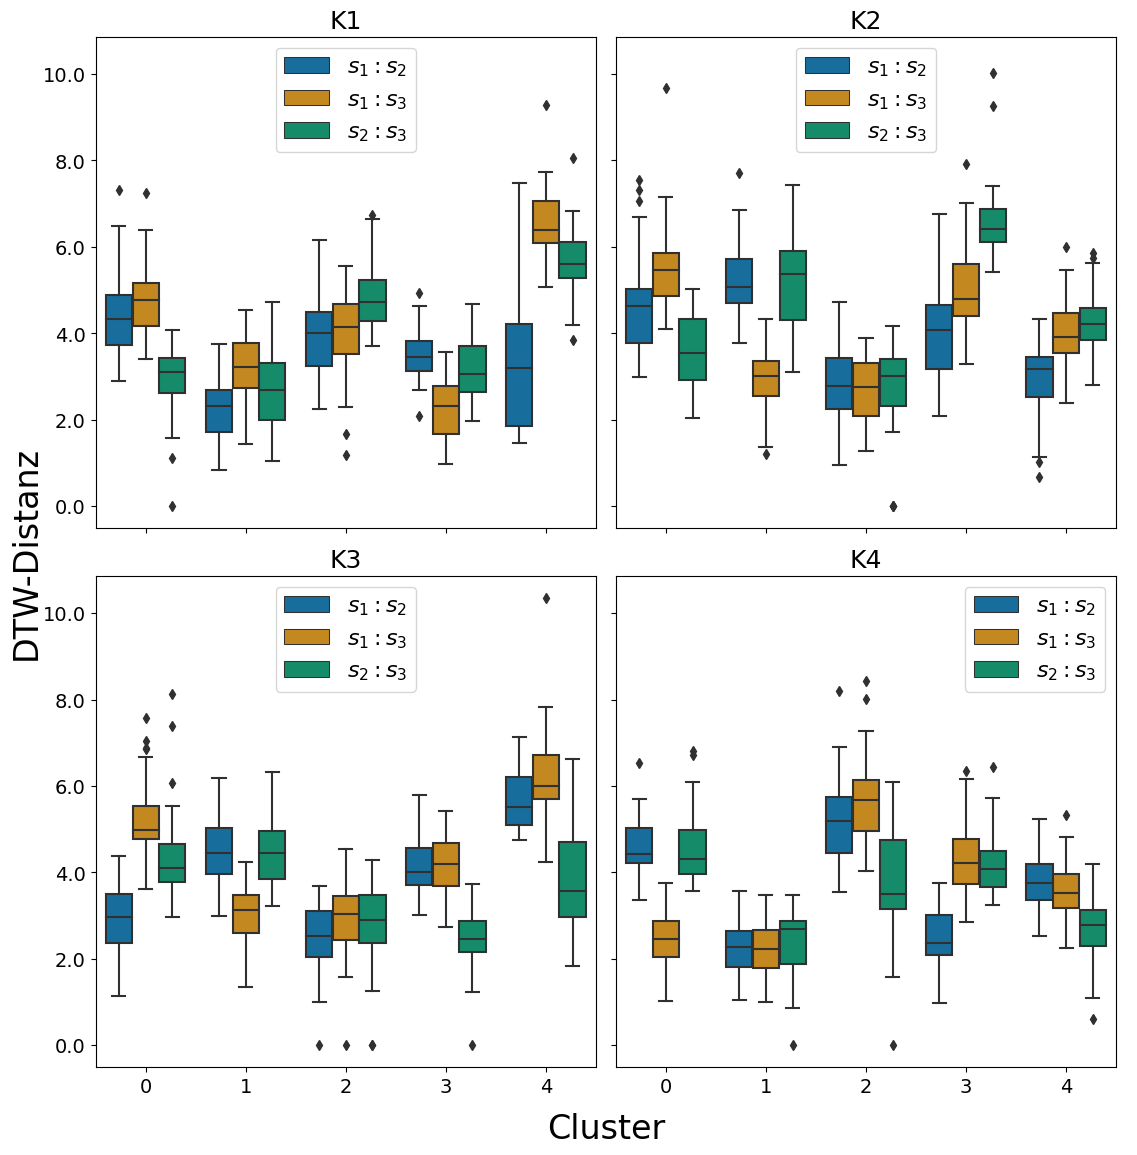

In [10]:
mpl.rc_file_defaults()
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,12))

g1 = sns.boxplot(x='cluster', y='distance',  data=df_long2, palette='colorblind', hue='segment', ax=axes[0,0])
g1.set_title('K1', fontsize=18)
g1.set(xlabel=None, ylabel=None)
g1.set_yticklabels(g1.get_yticks(), size=14)
g1.legend(loc='upper center', #title='Segment', 
          fontsize=16)

g2 = sns.boxplot(x='cluster', y='distance',  data=df_long4, palette='colorblind', hue='segment', ax=axes[0,1])
g2.set_title('K2', fontsize=18)
g2.set(xlabel=None, ylabel=None)
g2.legend(loc='upper center', #title='Segment', 
          fontsize=16)

g3 = sns.boxplot(x='cluster', y='distance',  data=df_long6, palette='colorblind', hue='segment', ax=axes[1,0])
g3.set_title('K3', fontsize=18)
g3.set(xlabel=None, ylabel=None)
g3.set_yticklabels(g3.get_yticks(), size=14)
g3.set_xticklabels(g3.get_xticks(), size=14)
g3.legend(loc='upper center', #title='Segment', 
          fontsize=16)

g4 = sns.boxplot(x='cluster', y='distance',  data=df_long8, palette='colorblind', hue='segment', ax=axes[1,1])
g4.set_title('K4', fontsize=18)
g4.set(xlabel=None, ylabel=None)
g4.set_yticklabels(g4.get_yticks(), size=14)
g4.set_xticklabels(g4.get_xticks(), size=14)
g4.legend(loc='upper right', #title='Segment', 
          fontsize=16)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Cluster", size=24, labelpad=15)
plt.ylabel("DTW-Distanz", size=24, labelpad=15)
plt.tight_layout()
plt.show()

# fig.savefig('/your_dir/figures/box_day_cluster.pdf',
#            bbox_inches='tight')

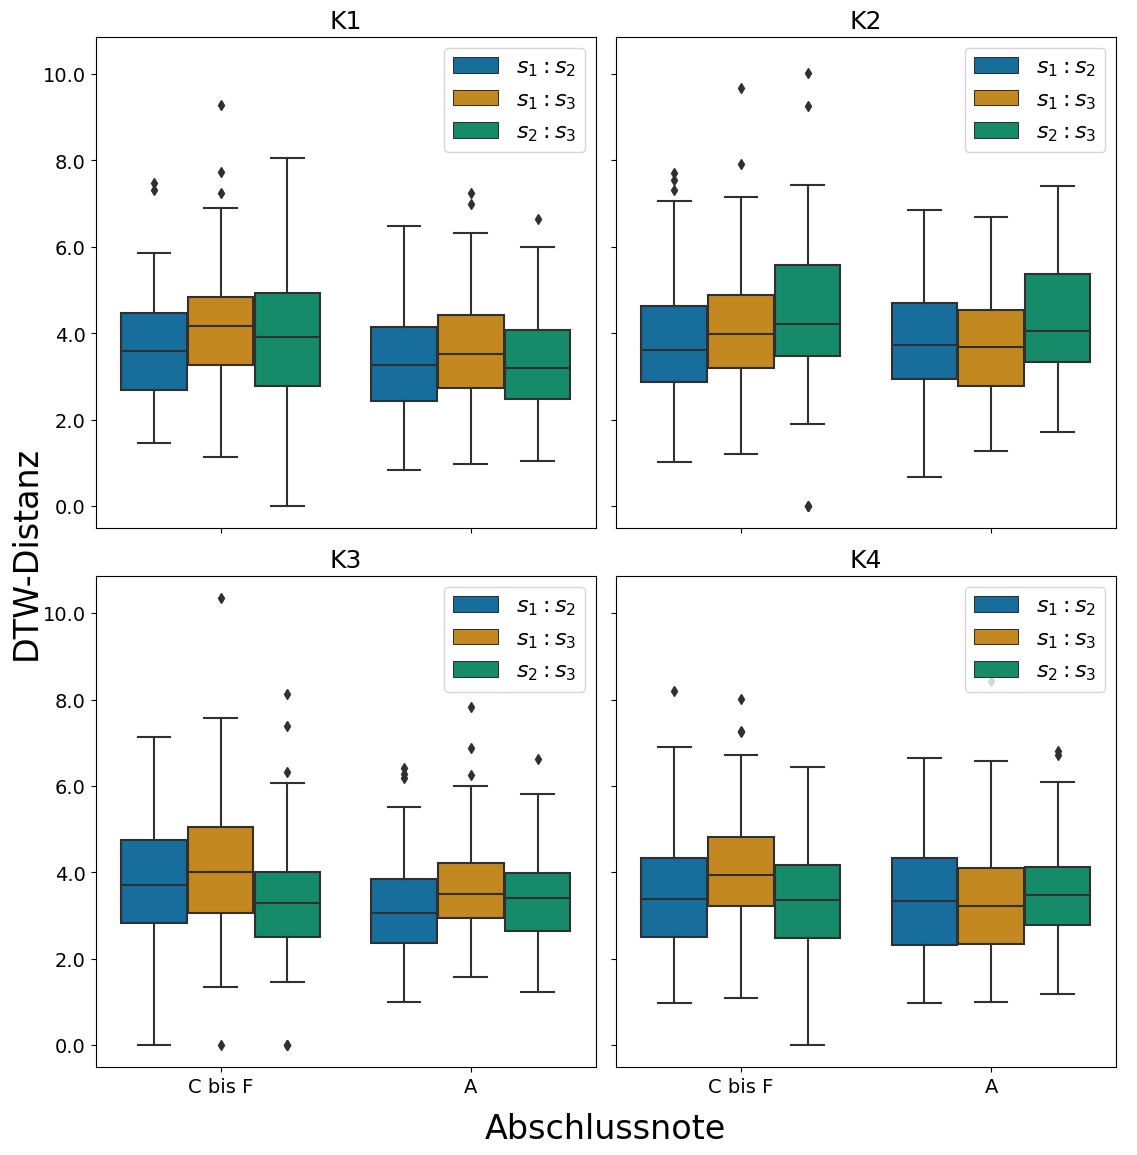

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(12,12))

g1 = sns.boxplot(x='final', y='distance',  data=df_long22, palette='colorblind', hue='segment', ax=axes[0,0])
g1.set_title('K1', fontsize=18)
g1.set(xlabel=None, ylabel=None)
g1.set_yticklabels(g1.get_yticks(), size=14)
g1.legend(loc='upper right', #title='Segment', 
          fontsize=16)

g2 = sns.boxplot(x='final', y='distance',  data=df_long44, palette='colorblind', hue='segment', ax=axes[0,1])
g2.set_title('K2', fontsize=18)
g2.set(xlabel=None, ylabel=None)
g2.legend(loc='upper right', #title='Segment', 
          fontsize=16)

g3 = sns.boxplot(x='final', y='distance',  data=df_long66, palette='colorblind', hue='segment', ax=axes[1,0])
g3.set_title('K3', fontsize=18)
g3.set(xlabel=None, ylabel=None)
g3.set_yticklabels(g3.get_yticks(), size=14)
g3.set_xticklabels(['C bis F', 'A'], size=14)
g3.legend(loc='upper right', #title='Segment', 
          fontsize=16)

g4 = sns.boxplot(x='final', y='distance',  data=df_long88, palette='colorblind', hue='segment', ax=axes[1,1])
g4.set_title('K4', fontsize=18)
g4.set(xlabel=None, ylabel=None)
g4.set_yticklabels(g4.get_yticks(), size=14)
g4.set_xticklabels(['C bis F', 'A'], size=14)
g4.legend(loc='upper right', #title='Segment', 
          fontsize=16)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Abschlussnote", size=24, labelpad=15)
plt.ylabel("DTW-Distanz", size=24, labelpad=15)
plt.tight_layout()
plt.show()

# fig.savefig('/your_dir/figures/box_day_exam.pdf',
#            bbox_inches='tight')